<a href="https://colab.research.google.com/github/rtajeong/Kyungnam_univ_M4/blob/main/lab104_gan_rev1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN (Generative Adversarial Netowrk)
- from Deep Learning with Python, by Francois Cholle
- CIFAR10 데이터셋의 이미지로 GAN을 훈련한다. 이 데이터셋은 32 × 32 크기의 RGB 이미지 50,000개로 이루어져 있고 10개의 클래스를 가집니다(클래스마다 5,000개의 이미지가 있습니다). 문제를 간단하게 만들기 위해 “frog” 클래스의 이미지만 사용하겠습니다.
- GAN 구조는 다음과 같습니다:
  - generator 네트워크는 (latent_dim,) 크기의 벡터를 (32, 32, 3) 크기의 이미지로 매핑합니다.
  - discriminator 네트워크는 (32, 32, 3) 크기의 이미지가 진짜일 확률을 추정하여 이진 값으로 매핑합니다.
  - 생성자와 판별자를 연결하는 gan 네트워크를 만듭니다. gan(x) = discriminator(generator(x)) 입니다. 이 gan 네트워크는 잠재 공간의 벡터를 판별자의 평가로 매핑합니다. 판별자는 생성자가 잠재 공간의 벡터를 디코딩한 것이 얼마나 현실적인지를 평가합니다.
  - “진짜"/”가짜" 레이블과 함께 진짜 이미지와 가짜 이미지 샘플을 사용해 판별자를 훈련합니다. 일반적인 이미지 분류 모델을 훈련하는 것과 동일합니다.
  - 생성자를 훈련하려면 gan 모델의 손실에 대한 생성자 가중치의 그래디언트를 사용합니다. 이 말은 매 단계마다 생성자에 의해 디코딩된 이미지를 판별자가 “진짜"로 분류하도록 만드는 방향으로 생성자의 가중치를 이동한다는 뜻입니다. 다른 말로하면 판별자를 속이도록 생성자를 훈련합니다.
- GAN 생성자와 판별자를 구현하는 데 사용할 몇 가지 기법
  - 생성자의 마지막 활성화로 다른 종류의 모델에서 널리 사용하는 sigmoid 대신 tanh 함수를 사용
  - 균등 분포가 아니고 정규 분포(가우시안 분포)를 사용하여 잠재 공간에서 포인트를 샘플링
  - 무작위성은 모델을 견고하게 만듭니다. GAN 훈련은 동적 평형을 만들기 때문에 여러 방식으로 갇힐 가능성이 높습니다. 훈련하는 동안 무작위성을 주입하면 이를 방지하는 데 도움이 됩니다. 무작위성은 두 가지 방법으로 주입합니다. 판별자에 드롭아웃을 사용하거나 판별자를 위해 레이블에 랜덤 노이즈를 추가
  - 희소한 그래디언트는 GAN 훈련을 방해할 수 있습니다. 딥러닝에서 희소는 종종 바람직한 현상이지만 GAN에서는 그렇지 않습니다. 그래디언트를 희소하게 만들 수 있는 것은 최대 풀링 연산과 ReLU 활성화 두 가지입니다. 최대 풀링 대신 스트라이드 합성곱을 사용해 다운샘플링을 하는 것이 좋습니다. 또 ReLU 활성화 대신 LeakyReLU 층을 사용하세요. ReLU와 비슷하지만 음수의 활성화 값을 조금 허용하기 때문에 희소가 조금 완화됩니다.
  - 생성자에서 픽셀 공간을 균일하게 다루지 못해 생성된 이미지에서 체스판 모양이 종종 나타납니다. 이를 해결하기 위해 생성자와 판별자에서 스트라이드 Conv2DTranpose나 Conv2D를 사용할 때 스트라이드 크기로 나누어질 수 있는 커널 크기를 사용한다.

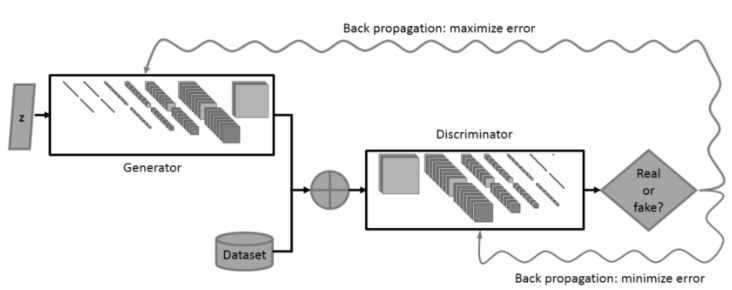

## Generator

In [ ]:
import keras 
from keras import layers
import numpy as np

latent_dim = 23
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

# 입력을 16 × 16 크기의 128개 채널을 가진 특성 맵으로 변환합니다
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

# 합성곱 층을 추가합니다
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# 32 × 32 크기로 업샘플링합니다
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

# 합성곱 층을 더 추가합니다
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# 32 × 32 크기의 1개 채널을 가진 특성 맵을 생성합니다
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 23)]              0         
_________________________________________________________________
dense (Dense)                (None, 32768)             786432    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 256)       104883

## Discriminator (판별자)

In [ ]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# 드롭아웃 층을 넣는 것이 아주 중요합니다!
x = layers.Dropout(0.4)(x)

# 분류 층
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

# 옵티마이저에서 (값을 지정하여) 그래디언트 클리핑을 사용합니다
# 안정된 훈련을 위해서 학습률 감쇠를 사용합니다
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 6, 6, 128)         0   

- Adversarial Network
- 마지막으로 생성자와 판별자를 연결하여 GAN을 설정합니다. 
- 훈련할 때 생성자가 판별자를 속이는 능력이 커지도록 학습합니다. 이 모델은 잠재 공간의 포인트를 “진짜" 또는 “가짜"의 분류 결정으로 변환합니다. 훈련에 사용되는 타깃 레이블은 항상 '진짜 이미지'입니다. 
- gan을 훈련하는 것은 discriminator가 가짜 이미지를 보았을 때 진짜라고 예측하도록 만들기 위해 generator의 가중치를 업데이트하는 것입니다. 훈련하는 동안 판별자를 동결(학습되지 않도록)하는 것이 아주 중요합니다. gan을 훈련할 때 가중치가 업데이트되지 않습니다. 판별자의 가중치가 훈련하는 동안 업데이트되면 판별자는 항상 “진짜"를 예측하도록 훈련됩니다. 

In [ ]:
# 판별자의 가중치가 훈련되지 않도록 설정합니다(gan 모델에만 적용됩니다)
discriminator.trainable = False
# 이 모델이 다른 모델에 층처럼 추가되었을 떄 학습되지 않도록 함.
# descriminator.fit() 로 판별자에 속한 layer 클라스 객체의 가중치를 학습할 때에는 
# 영향을 미치지 않음.

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

## DCGAN 훈련 방법
- 매 반복마다 다음을 수행합니다.
  - 1.잠재 공간에서 무작위로 포인트를 뽑습니다(랜덤 노이즈).
  - 2.이 랜덤 노이즈를 사용해 `generator`에서 이미지를 생성합니다.
  - 3.생성된 이미지와 진짜 이미지를 섞습니다.
  - 4.진짜와 가짜가 섞인 이미지와 이에 대응하는 타깃을 사용해 `discriminator`를 훈련합니다. 타깃은 “진짜"(실제 이미지일 경우) 또는 “가짜"(생성된 이미지일 경우)입니다.
  - 5.잠재 공간에서 무작위로 새로운 포인트를 뽑습니다.
  - 6.이 랜덤 벡터를 사용해 `gan`을 훈련합니다. 모든 타깃은 “진짜"로 설정합니다. 판별자가 생성된 이미지를 모두 “진짜 이미지"라고 예측하도록 생성자의 가중치를 업데이트합니다(`gan` 안에서 판별자는 동결되기 때문에 생성자만 업데이트합니다). 결국 생성자는 판별자를 속이도록 훈련합니다.

In [ ]:
import os
from keras.preprocessing import image

# CIFAR10 데이터를 로드합니다
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# 개구리 이미지를 선택합니다(클래스 6)
x_train = x_train[y_train.flatten() == 6]

# 데이터를 정규화합니다
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
save_dir = './gan_images/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

# 훈련 반복 시작
start = 0
for step in range(iterations):
    # 잠재 공간에서 무작위로 포인트를 샘플링합니다
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # 가짜 이미지를 디코딩합니다
    generated_images = generator.predict(random_latent_vectors)

    # 진짜 이미지와 연결합니다
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # 진짜와 가짜 이미지를 구분하여 레이블을 합칩니다
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # 레이블에 랜덤 노이즈를 추가합니다. 아주 중요합니다!
    labels += 0.05 * np.random.random(labels.shape)

    # discriminator를 훈련합니다
    d_loss = discriminator.train_on_batch(combined_images, labels)  # fit

    # 잠재 공간에서 무작위로 포인트를 샘플링합니다
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # 모두 “진짜 이미지"라고 레이블을 만듭니다
    misleading_targets = np.zeros((batch_size, 1))

    # generator를 훈련합니다(gan 모델에서 discriminator의 가중치는 동결됩니다)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)  # fit
    
    start += batch_size
    if start > len(x_train) - batch_size:
      start = 0

    # 중간 중간 저장하고 그래프를 그립니다
    if step % 100 == 0:
        # 모델 가중치를 저장합니다
        gan.save_weights('gan.h5')

        # 측정 지표를 출력합니다
        print('스텝 %s에서 판별자 손실: %s' % (step, d_loss))
        print('스텝 %s에서 적대적 손실: %s' % (step, a_loss))

        # 생성된 이미지 하나를 저장합니다
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

        # 비교를 위해 진짜 이미지 하나를 저장합니다
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

- 가짜 이미지 몇개를 출력

In [ ]:
import matplotlib.pyplot as plt

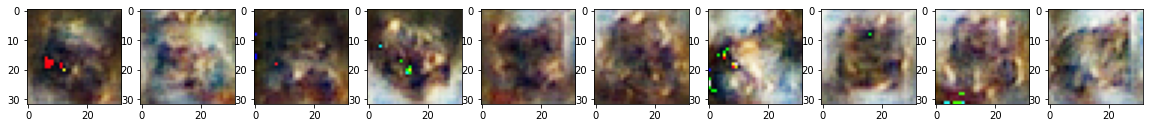

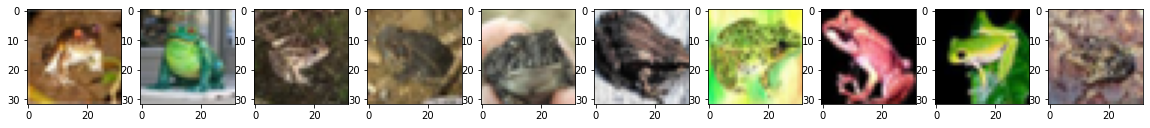

In [ ]:
# 잠재 공간에서 랜덤한 포인트를 샘플링합니다
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# 가짜 이미지로 디코딩합니다
generated_images = generator.predict(random_latent_vectors)

plt.figure(figsize=(20, 4))
for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    ax = plt.subplot(1, 10, i+1)
    plt.imshow(img)
    
plt.show()

# some of train images (frogs)
plt.figure(figsize=(20, 4))
for i in range(10):
    img = x_train[i]
    ax = plt.subplot(1, 10, i+1)
    plt.imshow(img)

plt.show()

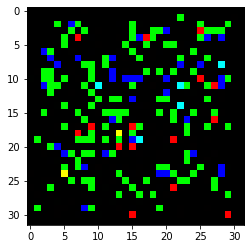

In [ ]:
import matplotlib.image as mpimg
img = mpimg.imread('./gan_images/generated_frog0.png')
plt.imshow(img)
plt.show()

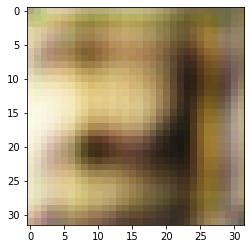

In [ ]:
img = mpimg.imread('./gan_images/generated_frog100.png')
plt.imshow(img)
plt.show()

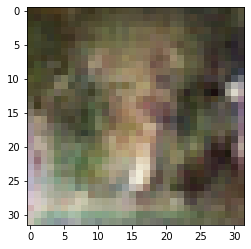

In [ ]:
img = mpimg.imread('./gan_images/generated_frog9900.png')
plt.imshow(img)
plt.show()

- AI image synthesis has made impressive progress since Generative Adversarial Networks (GANs) were introduced in 2014. 
- GANs were originally only capable of generating small, blurry, black-and-white pictures, but now we can generate high-resolution, realistic and colorful pictures that you can hardly distinguish from real photographs.
- Here we have summarized for you 5 recently introduced GAN architectures that are used for image synthesis.
- https://www.topbots.com/ai-research-generative-adversarial-network-images/
- many example images are avilable by searching google